# Programming Exercise 4, Problem 2: Viterbi Algorithm

The goal of this task is to learn about the how to implement the Viterbi algorithm for a hidden Markov model.

Image you have a sweeping robot vacuum cleaner at home to help you keep the floor clean. 
The robot has a camera for detecting the floor color beneath it to help it localize itself.
But the camera is not perfect. 
So, the robot might also observe other colors instead of the actual floor color with a low probability.
Now, we help our robot to get the most likely sequence of its positions based on the sequences of detected color.

Your tasks is to complete the missing code. Make sure that all the functions follow the provided interfaces of the functions, i.e. the output of the function exactly matches the description in the docstring.
Adding or modifying code outside of the following comment blocks is not required:

```
##########################################################
# YOUR CODE HERE
.....
##########################################################
```

### Learing Outcomes:

* implement prior matrix, transition model, sensor model
* implement viterbi algorithm

### Import

For testing and grading, we want to state that you are not allowed to import 
any other libraries and should not change the structure of the provided functions 
(i.a. the arguments and the name of the functions).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import random
import os
import ipywidgets 

### Map Representation (Nothing to change here)

At first, we create a rectangular map; the floor color will be choosen randomly from a given colorlist.
See section "Create Map" for an example visualization.

We use NetworkX 2d graph to represent the map. The nodes represent robot possible positions.
If two nodes are connected with an egde, it means the robot can move between them. To get more information about networkx:
https://networkx.org/documentation/latest/release/release_dev.html

In [2]:
def create_rect_map(x_dim = 3, y_dim = 3,colorlist = ["red","green","blue"]):
    """create a rectangular map given the map size and colorlist
    
    Args:
        x_dim: number of grids in x dimension, Horizontal 
        y_dim: number of grids in y dimension, Vertical
        colorlist: a list of color name
    
    Return:
        Graph: a 2d networkx graph
    """
    
    assert x_dim > 0, "x dimension should be larger than zero"
    assert y_dim > 0, "y dimension should be larger than zero"
    assert len(colorlist) > 0, "color list can't be empty"
    
    # create a 2d NetworkX graph 
    Graph = nx.grid_2d_graph(x_dim,y_dim)
    
    # add x_dim and y_dim as graph attribute
    Graph.graph['x_dim'] = x_dim
    Graph.graph['y_dim'] = y_dim
    
    # add the across edges, which connect the lower left and upper right nodes, also
    # the lower right and upper left nodes
    for i, j in Graph.nodes():
        if (i + 1 < x_dim) and (j + 1 < y_dim):
            Graph.add_edge((i,j), (i + 1, j + 1))
        if (i + 1 < x_dim) and (j - 1 >= 0) :
            Graph.add_edge((i,j), (i + 1, j - 1))
            
        # randomly assign color to each node and add color as an attibute of node
        Graph.nodes[(i,j)]['color'] = random.choice(colorlist)

    # a labels dictionary to map the (x,y) to a number(starting from 0) in order
    labels = {}
    # a inverse labels dictionary to map the number(starting from 0) to (x,y) in order
    labels_inv = {}

    for index, (i,j) in enumerate (Graph.nodes()):
        labels[(i,j)] = index
        labels_inv[index] = (i,j)
        
    # add labels dictionary and labels inv dictinary as graph attribute    
    Graph.graph['labels'] = labels
    Graph.graph['labels_inv'] = labels_inv
             
    return Graph
    

The map shows the robot possible position, 
connecticity between position and the floor color for each position.

In [3]:
def draw_map(Graph, show_labels = False, nodelist = None):
    
    """ Map Visualization
    
    Args:
        Graph: 2d NetworkX graph
        show_labels: False: shows (x,y) upon the node
                     True: shows number upon the node
        nodelist: only shows the node in nodelist

    """
    
    # get x_dim, y_dim and labels from graph attributes
    x_dim = Graph.graph['x_dim']
    y_dim = Graph.graph['y_dim']
    labels = Graph.graph['labels']
    
    # node position in figure
    pos = dict( (n, n) for n in Graph.nodes())
    
    # to store the node color in order
    node_color = []
    if (nodelist == None):
        for (x,y),color in Graph.nodes.data('color'):
            node_color.append(color)
    else:
        for node in nodelist:
            node_color.append(Graph.nodes[node]['color'])
            
    # draw the map
    plt.figure(figsize = (x_dim,y_dim), dpi = 100)
    
    if show_labels == True:
        # node_shape='s' node will be drawn as a square   
        # node_shape='o' node will be drawn as a circle 
        nx.draw_networkx(Graph,node_shape='o',nodelist = nodelist, node_color = node_color, 
                         node_size = 1000, font_size =10, pos=pos,labels = labels)
    else:
        nx.draw_networkx(Graph,node_shape='o',nodelist = nodelist, node_color = node_color, 
                         node_size = 1000, font_size =10, pos=pos)
    
    plt.axis('off')
    plt.xlim(-1, x_dim)
    plt.ylim(-1, y_dim)
    plt.show()
    

In [4]:
# only the color in colorlist will be used
colorlist = ["pink","red","orange","yellow","green","blue","purple","grey"]

### Create Map

Create a map with random color, you can also change the map size or 
choose different colors from the colorlist. Execute the cell below to get an idea of what the map looks like.

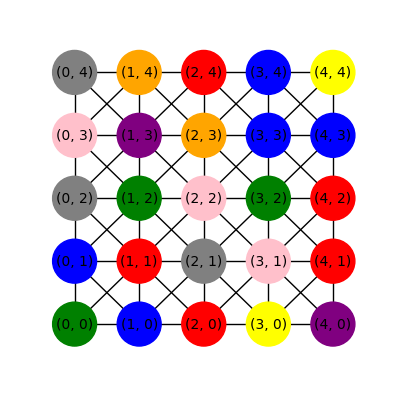

In [5]:
# number of grids in x dimension, Horizontal, change it to create different map
x_dim = 5
# number of grids in y dimension, Vertical, change it to create different map
y_dim = 5
# please only use the colors that exist in colorlist, change it to create different map
colors = ["pink","red","orange","yellow","green","blue","purple","grey"]

Graph = create_rect_map(x_dim, y_dim, colors)

draw_map(Graph)

# uncomment to only print the nodes
# print(Graph.nodes)

# uncomment to print the nodes with color information
# print(Graph.nodes(data=True))

# uncomment to print the egdes
# print(Graph.edges)

To better identify the node, we assign a number as label (starting from 0) for each node. The order is based on the node order when printing Graph.nodes().

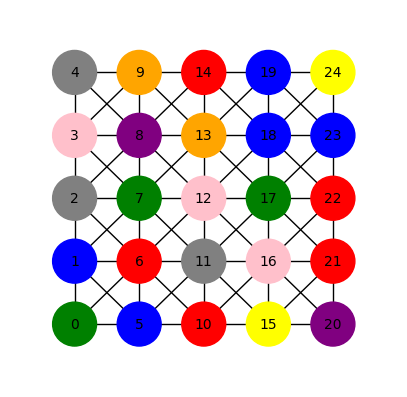

In [6]:
# draw the map with showing the number of the nodes
draw_map(Graph, show_labels = True)

To convert our robot localization task into a hidden markov model problem. 
We consider position as the hidden state $X_t$. Observed color by the camera as the observable variable $E_t$.

### Define prior matrix

If no further information is provided, we assume that the robot can start from any position with same probability.

In [7]:
def get_prior(Graph):
    
    """ given the NetworkX 2d graph, return the prior matrix.
        The robot can start from any position with same probability.
    
    Args:
        Graph: 2d NetworkX graph
        
    Return: 
        prior: numpy array with shape = [S,1], (number_nodes: number of nodes)

    """
    number_nodes = len(Graph.nodes())
    #######################################
    prior=np.ones((number_nodes))/number_nodes
    prior=prior.reshape(-1,1)

    #######################################
    return prior

In [8]:
prior = get_prior(Graph)
#print(prior)

### Define transition model

Let $S$ be the number of possible states.
The transition model $P(X_t | X_{t−1} )$ becomes an $S × S$ matrix $T$, where
$T_{ij} = P (X_t = j | X_{t−1} = i)$.
That is, $T_{ij}$ is the probability of a transition from state i to state j.

If one position is connected to other neighbor position (i.e., there is an egde between the nodes), then the robot can move between them.
The robot has the same probability to move from the current position to all of its neighbors.

In [9]:
def get_transition_model(Graph):
    """ given the NetworkX 2d graph, return the transition model matrix.
       
    Args:
        Graph: 2d NetworkX graph
        
    Return: 
        transition_model: numpy array with shape = [S, S], (S: number of nodes)

    """
    
    # An adjacency matrix A is a square matrix used to represent a finite graph.
    # The elements A_ij of the matrix indicate whether pairs of nodes i,j are adjacent (A_ij=1)
    # or not (A_ij=0) in the graph.
    
    # adjacency_matrix is a SciPy sparse matrix. We convert it to a dense matrix, i.e. a usual numpy array.
    adjacency_matrix = nx.adjacency_matrix(Graph).todense()
    
    # transform SciPy matrix to numpy array
    adjacency_matrix = np.asarray(adjacency_matrix)
    
    #######################################
    transition_model=adjacency_matrix/adjacency_matrix.sum(axis=1,keepdims=True)
    
    #######################################
    
    return transition_model

In [10]:
transition_model = get_transition_model(Graph)
#print(transition_model[0])

### Define sensor model

$C$ is the number of color types. 
The conditional probability matrix `color_matrix` is a $C × C$ matrix.
`color_matrix[i,j]` is the probability of observing a color i while being on a node with color j.

In [11]:
color_matrix = np.eye(len(colorlist)) * 0.5 + 0.2
#color_matrix=color_matrix/color_matrix.sum(axis=1,keepdims=True)
#print(color_matrix)

Then the sensor model $P(E_t | X_t )$ is a $S × C$ matrix $O$, where
$O_{ij} = P (E_t = j | X_t = i)$.
That is, $O_{ij}$ is the probability of being in state i to observe variable j.

In [12]:
def get_sensor_model(Graph, colorlist, color_matrix):
    """ given the NetworkX 2d graph, colorlist, color_matrix, return the sensor model matrix.
       
    Args:
        Graph: 2d NetworkX graph
        colorlist: a list of color name
        color_matrix: numpy array, conditional probability matrix
        
    Return: 
        sensor_model: S * C numpy array (S: number of nodes, C: number of color types)

    """
    
    sensor_model = np.zeros((len(Graph.nodes()),len(colorlist)))
    
    for num,(node,node_color) in enumerate(Graph.nodes.data('color')):
        #######################################
        #print(node)
        sensor_model[num]=color_matrix[colorlist.index(node_color)]
      
        #######################################
    return sensor_model

In [13]:
sensor_model = get_sensor_model(Graph,colorlist,color_matrix)
#print(sensor_model)

### Define HMM (nothing to change here)

In [14]:
class HiddenMarkovModel:
    """ Hidden Markov Model
       
    Args:
        Graph: 2d NetworkX graph
        colorlist: a list of color name
        color_matrix: numpy array, conditional probability matrix
        transition_model: S * S numpy array (S: number of nodes)
        sensor_model: S * C numpy array (S: number of nodes, C: number of color types)
        prior: S * 1 numpy array (S: number of nodes)

    """
  
    def __init__(self, Graph,colorlist, color_matrix, transition_model= None, 
                 sensor_model= None, prior = None):
        
        self.Graph = Graph
        self.colorlist = colorlist
        self.color_matrix = color_matrix
        
        if transition_model != None:
            self.transition_model = transition_model
        else:
            self.transition_model = get_transition_model(Graph)
        if sensor_model != None:
            self.sensor_model = sensor_model
        else:
            self.sensor_model = get_sensor_model(Graph,colorlist,color_matrix)
        if prior != None:    
            self.prior = prior
        else:
            self.prior = get_prior(Graph)

### Viterbi Algorithm

The robot observes a sequence of colors. Use the Viterbi algorithm to compute the most likely sequence of nodes.
Keep in mind: Most likely sequence $ \neq $ sequence of most likely states...

def return_most_likely_trajectory(HMM, obs_trajectory):
    """use Viterbi algorithm to get the most likely trajectory of robot 
       given observed color sequence
    
    Args:
        HMM: an object of class HiddenMarkovModel
        obs_trajectory: observed color sequence, a list of color names
    
    Return:
        most_likely_trajectory: a numpy array of node labels, e.g. [0 2 1 3]
        most_likely_trajectory and obs_trajectory should has the same length 
    """
    Graph = HMM.Graph
    color_matrix = HMM.color_matrix
   # color_matrix=color_matrix/color_matrix.sum(axis=1,keepdims=True)
    colorlist = HMM.colorlist
    most_likely_trajectory = np.zeros(len(obs_trajectory),dtype = int)
    A=HMM.transition_model
    B=HMM.sensor_model
    C=HMM.prior.reshape(-1)
    
    O=np.zeros(len(obs_trajectory),dtype = int)
    for num,node_color in enumerate(obs_trajectory):
        #######################################
        O[num]=colorlist.index(node_color)
        
    I = A.shape[0]    # Number of states
    N = len(O)  # Length of observation sequence

    
    D = np.zeros((I, N))
    E = np.zeros((I, N-1)).astype(np.int32)
    D[:, 0] = np.multiply(C, B[:, O[0]])
    
    for n in range(1, N):
        for i in range(I):
            temp_product = np.multiply(A[:, i], D[:, n-1])
            D[i, n] = np.max(temp_product) * B[i, O[n]]
            E[i, n-1] = np.argmax(temp_product)
   # print(E)
    # Backtracking
  #  S_opt = np.zeros(N).astype(np.int32)
    #print(E)
    most_likely_trajectory[-1] = np.argmax(D[:, -1])
    for n in range(N-2, -1, -1):
        most_likely_trajectory[n] = E[int(most_likely_trajectory[n+1]), n]
      

  #  most_likely_trajectory=S_opt
  
    #######################################

    return most_likely_trajectory

In [37]:
def return_most_likely_trajectory(HMM, obs_trajectory):
    """use Viterbi algorithm to get the most likely trajectory of robot 
       given observed color sequence
    
    Args:
        HMM: an object of class HiddenMarkovModel
        obs_trajectory: observed color sequence, a list of color names
    
    Return:
        most_likely_trajectory: a numpy array of node labels, e.g. [0 2 1 3]
        most_likely_trajectory and obs_trajectory should has the same length 
    """
    Graph = HMM.Graph
    color_matrix = HMM.color_matrix
    colorlist = HMM.colorlist
    most_likely_trajectory = np.zeros(len(obs_trajectory),dtype = int)
    A=HMM.transition_model
    B=HMM.sensor_model
    pi=HMM.prior.reshape(-1)
    
    O=np.zeros(len(obs_trajectory),dtype = int)
    for num,node_color in enumerate(obs_trajectory):
        #######################################
        O[num]=colorlist.index(node_color)
        
    T = len(O)
    N = len(A[0])
    
    delta = [[0]*N for _ in range(T)]
    psi = [[0]*N for _ in range(T)]
    
    #step1: init
    for i in range(N):
        delta[0][i] = pi[i]*B[i][O[0]]
        psi[0][i] = 0
        
    #step2: iter
    for t in range(1,T):
        for i in range(N):
            temp,maxindex = 0,0
            for j in range(N):
                res = delta[t-1][j]*A[j][i]
                if res>temp:
                    temp = res
                    maxindex = j

            delta[t][i] = temp*B[i][O[t]]#delta
            psi[t][i] = maxindex

    #step3: end
    p = max(delta[-1])
    for i in range(N):
        if delta[-1][i] == p:
            i_T = i

    #step4：backtrack
    path = [0]*T
    i_t = i_T
    for t in reversed(range(T-1)):
        i_t = psi[t+1][i_t]
        path[t] = i_t
    path[-1] = i_T
    most_likely_trajectory=path


  #  most_likely_trajectory=S_opt
  
    #######################################

    return most_likely_trajectory

In [39]:
def return_most_likely_trajectory(HMM, obs_trajectory):
    """use Viterbi algorithm to get the most likely trajectory of robot 
       given observed color sequence
    
    Args:
        HMM: an object of class HiddenMarkovModel
        obs_trajectory: observed color sequence, a list of color names
    
    Return:
        most_likely_trajectory: a numpy array of node labels, e.g. [0 2 1 3]
        most_likely_trajectory and obs_trajectory should has the same length 
    """
    
    def step(mu_prev: np.ndarray,
         emission_probs: np.ndarray,
         transition_probs: np.ndarray,
         observed_state: int) -> [np.ndarray, np.ndarray]:
    
        pre_max = mu_prev * transition_probs.T
        max_prev_states = np.argmax(pre_max, axis=1)
        max_vals = pre_max[np.arange(len(max_prev_states)), max_prev_states]
        mu_new = max_vals * emission_probs[:, observed_state]

        return mu_new, max_prev_states
    colorlist = HMM.colorlist
    most_likely_trajectory = np.zeros(len(obs_trajectory),dtype = int)
    #######################################
    # YOUR CODE HERE
    # TO DO： implement the Viterbi algorithm to get the most likely trajectory
    # from https://www.audiolabs-erlangen.de/resources/MIR/FMP/C5/C5S3_Viterbi.html 
    Graph = HMM.Graph
    color_matrix = HMM.color_matrix
    
    transition_probs=HMM.transition_model
    emission_probs=HMM.sensor_model
    start_probs=HMM.prior.reshape(-1)
    
    observed_states=np.zeros(len(obs_trajectory),dtype = int)
    for num,node_color in enumerate(obs_trajectory):
        #######################################
        observed_states[num]=colorlist.index(node_color)
    
    mu = start_probs * emission_probs[:, observed_states[0]]
    all_prev_states = []
    for observed_state in observed_states[1:]:
        mu, prevs = step(mu, emission_probs, transition_probs, observed_state)
        all_prev_states.append(prevs)
    
    # Traces backwards to get the maximum likelihood sequence.
    state = np.argmax(mu)
    sequence_prob = mu[state]
    state_sequence = [state]
    for prev_states in all_prev_states[::-1]:
        state = prev_states[state]
        state_sequence.append(state)
    most_likely_trajectory=state_sequence[::-1]
    #######################################

    return most_likely_trajectory

 def return_most_likely_trajectory(HMM, obs_trajectory):
    """use Viterbi algorithm to get the most likely trajectory of robot 
       given observed color sequence
    
    Args:
        HMM: an object of class HiddenMarkovModel
        obs_trajectory: observed color sequence, a list of color names
    
    Return:
        most_likely_trajectory: a numpy array of node labels, e.g. [0 2 1 3]
        most_likely_trajectory and obs_trajectory should has the same length 
    """
    
    colorlist = HMM.colorlist
    most_likely_trajectory = np.zeros(len(obs_trajectory),dtype = int)
    #######################################
    # YOUR CODE HERE
    # TO DO： implement the Viterbi algorithm to get the most likely trajectory
    # from https://ben.bolte.cc/viterbi
    Graph = HMM.Graph
    color_matrix = HMM.color_matrix
    
    transition_probs=HMM.transition_model
    emission_probs=HMM.sensor_model
    start_probs=HMM.prior.reshape(-1)
    
    observed_states=np.zeros(len(obs_trajectory),dtype = int)
    for num,node_color in enumerate(obs_trajectory):
        #######################################
        observed_states[num]=colorlist.index(node_color)
    
    mu = start_probs * emission_probs[:, observed_states[0]]
    all_prev_states = []
    for observed_state in observed_states[1:]:
        
        pre_max = mu * transition_probs.T
        max_prev_states = np.argmax(pre_max, axis=1)
        max_vals = pre_max[np.arange(len(max_prev_states)), max_prev_states]
        mu = max_vals * emission_probs[:, observed_state]
        
      #  mu, prevs = step(mu, emission_probs, transition_probs, observed_state)
        all_prev_states.append(max_prev_states)
    
    # Traces backwards to get the maximum likelihood sequence.
    state = np.argmax(mu)
    sequence_prob = mu[state]
    state_sequence = [state]
    for prev_states in all_prev_states[::-1]:
        state = prev_states[state]
        state_sequence.append(state)
    most_likely_trajectory=state_sequence[::-1]
  
    #######################################

    return most_likely_trajectory

### Visualization (nothing to change here)

In [16]:
def draw_trajectory(Graph, most_likely_trajectory):
    
    """ draw the estimated trajectory
    
    Args:
        Graph: 2d NetworkX graph
        most_likely_trajectory: a numpy array of node labels
        
    """
    
    labels = Graph.graph['labels']
    labels_inv = Graph.graph['labels_inv']
    nodelist = []
    
    # get the nodes which will be shown
    for state in most_likely_trajectory:
        for key,value in labels.items():
            if value == state:
                nodelist.append(key)
    
    # directed graph 
    DiGraph = nx.DiGraph()
    DiGraph.graph = Graph.graph
    
    # add nodes from Graph
    DiGraph.add_nodes_from(Graph)
    for node in DiGraph.nodes():
        DiGraph.nodes[node]['color'] = Graph.nodes[node]['color'] 

    # add edges
    for i in range(len(most_likely_trajectory)-1):
        
        first = labels_inv[most_likely_trajectory[i]]
        second = labels_inv[most_likely_trajectory[i+1]]
    
        DiGraph.add_edge(first,second )
        
    draw_map(DiGraph, True,nodelist)

First, suppose the robot starts at any point and observes a sequence of colors.
We show the results of the Viterbi algorithm below.

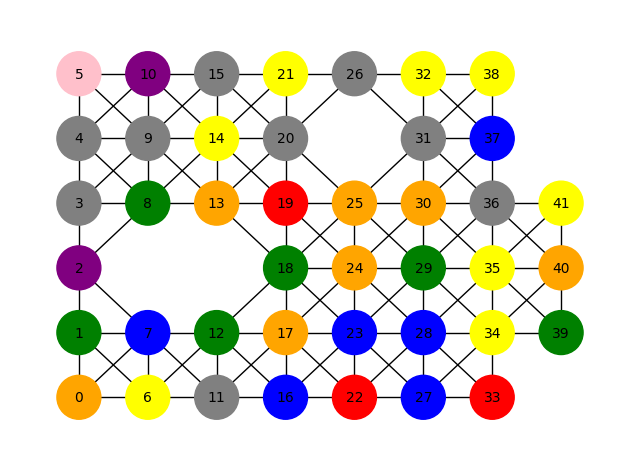

In [17]:
# load predefinded graphs in data folder
Graph = nx.read_gpickle("data/HMM_data/8_6.gpickle")
# use the graph, colorlist and color_matirx to generate a hidden markov model
hmm = HiddenMarkovModel(Graph, colorlist, color_matrix)
# visualize the graph with labels
draw_map(hmm.Graph, show_labels = True)

most_likely_trajectory: [23 24 19 20 26 31 36 41 40 39 34 27]


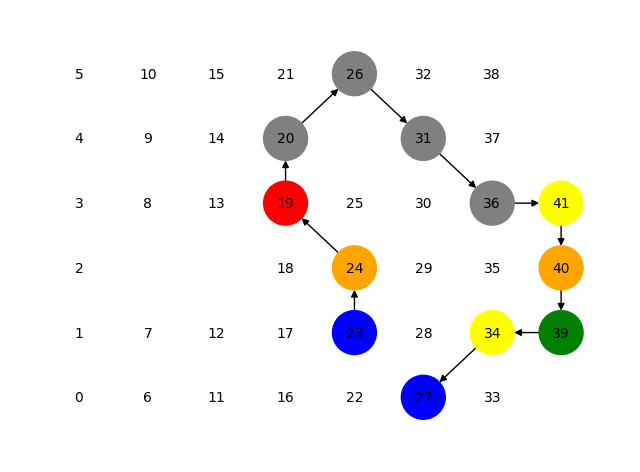

In [18]:
# robot observed color sequences
obs_trajectory = [ "blue","orange","red", "grey", "grey","grey","grey","yellow","orange","green","yellow","blue"]

# get the most likely trajectory
most_likely_trajectory = return_most_likely_trajectory(hmm,obs_trajectory)
print("most_likely_trajectory:", most_likely_trajectory)
draw_trajectory(hmm.Graph,most_likely_trajectory)

In [19]:
def vis_by_step(step):
    most_likely_trajectory = return_most_likely_trajectory(hmm,obs_trajectory[0:step])
    print("most likely trajectory:", most_likely_trajectory)
    draw_trajectory(hmm.Graph,most_likely_trajectory)

You can use your mouse to move the slider to see how the estimated trajectory changes over time.

In [20]:
x_widget = ipywidgets.IntSlider(min = 1, max = len(obs_trajectory), step = 1)
vis = ipywidgets.interact(vis_by_step, step = x_widget)

interactive(children=(IntSlider(value=1, description='step', max=12, min=1), Output()), _dom_classes=('widget-…

Now suppose the robot can only start at point A. What is the most likely trajectory?

most_likely_trajectory: [1, 0, 1, 6, 11, 6, 11, 6, 0, 1, 6, 7]


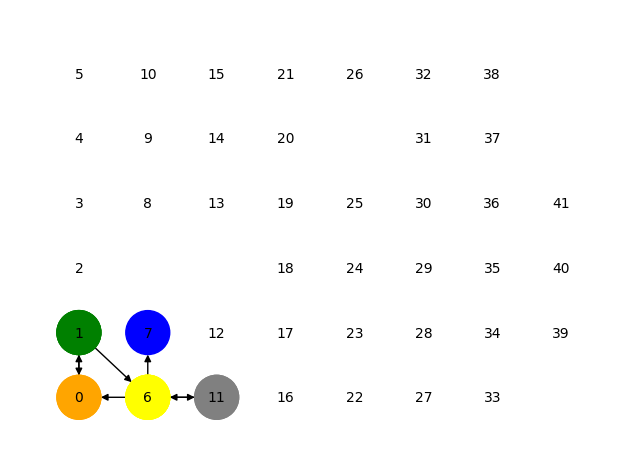

In [40]:
# load predefinded graphs in data folder
Graph = nx.read_gpickle("data/HMM_data/8_6.gpickle")
# use the graph, colorlist and color_matrix to generate a hidden markov model
hmm_1 = HiddenMarkovModel(Graph, colorlist, color_matrix)
# define the prior matrix based on the information
hmm_1.prior = np.full((len(Graph.nodes()),), 0)

# you can change this to see the differences
start_position = 1
hmm_1.prior[start_position] = 1

most_likely_trajectory = return_most_likely_trajectory(hmm_1,obs_trajectory)
print("most_likely_trajectory:", most_likely_trajectory)

draw_trajectory(Graph,most_likely_trajectory)

In [22]:
def vis_by_step_2(step):
    most_likely_trajectory = return_most_likely_trajectory(hmm_1,obs_trajectory[0:step])
    print("most likely trajectory:", most_likely_trajectory)
    draw_trajectory(hmm.Graph,most_likely_trajectory)

x_widget = ipywidgets.IntSlider(min = 1, max = len(obs_trajectory), step = 1)
vis = ipywidgets.interact(vis_by_step_2, step = x_widget)

interactive(children=(IntSlider(value=1, description='step', max=12, min=1), Output()), _dom_classes=('widget-…

### Try it out

We provide a method to randomly generate observations of the graph.
You can load other predefinded graphs in the data folder or change the color matrix to see the hidden markov model performance.

In [23]:
def randomly_generate_obs_trajectory(Graph,n):
    """ randomly generate a trajectory with length of n
    
    Args:
        Graph: 2d NetworkX graph
        n: the length of the trajectory
    
    Return:
        truth_trajectory_lables: a list of labels, e.g. [0, 2, 1, 3]
        obs_trajectory: a list of color name 
    """
    
    number_node = len(Graph.nodes)
    # list of node
    truth_trajectory = []
    # list of node color
    obs_trajectory =[]
    # list of node label
    truth_trajectory_lables = []
    
    labels_inv = Graph.graph['labels_inv']
    labels = Graph.graph['labels']
    
    # randomly choose the first node
    first = labels_inv[random.choice(range(0,number_node-1))]
    # add the node at the end of the list
    truth_trajectory.append(first)
    obs_trajectory.append(Graph.nodes[first]['color'] )
    
    for i in range(0,n-1):
        
        # get the last node in trajectory
        last_node = truth_trajectory[-1]
        # get the neighbors of the last node
        neighbors = [nb for nb in Graph.neighbors(last_node)]
        # randomly choose a node in the neighbors of the last node
        new_node = random.choice(neighbors)
        
        # add the node at the end of the list
        truth_trajectory.append(new_node)
        obs_trajectory.append(Graph.nodes[new_node]['color'] )
        
    # convert the list with node labels to the list of node
    for node in truth_trajectory:
        truth_trajectory_lables.append(labels[node])
        
    return truth_trajectory_lables, obs_trajectory

['10_5.gpickle', '3_3.gpickle', '5_3.gpickle', '5_5.gpickle', '8_6.gpickle']


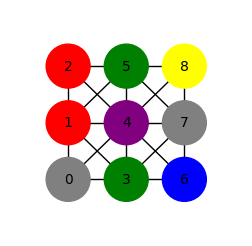

In [24]:
# show predefinded graphs in data folder
path = os.getcwd() + "/data/HMM_data"
print(os.listdir(path))

# load predefinded graphs in data folder
# You can change the filename to load different graph.
Graph_random = nx.read_gpickle("data/HMM_data/3_3.gpickle")

# You can also try different color matrices
# For example, if the camera is very precise, it observes the correct color with a higher probability.
# The matrix may looks like this:
color_matrix_test = np.eye(len(colorlist)) * 0.5 + 0.01

hmm_random = HiddenMarkovModel(Graph_random, colorlist, color_matrix_test)

draw_map(hmm_random.Graph, show_labels = True)

This figure shows the true trajectory.

truth trajectory with lables: [6, 4, 7, 5, 2]


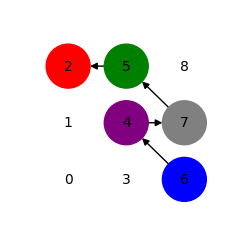

In [29]:
obs_length = 5

truth_trajectory_lables, obs_trajectory_random = randomly_generate_obs_trajectory(Graph_random, obs_length)
print ("truth trajectory with lables:", truth_trajectory_lables)

draw_trajectory(Graph_random,truth_trajectory_lables)

This figure shows the estimated trajectory using hidden markov model and viterbi algorithms.

most likely trajectory: [6, 4, 0, 3, 1]


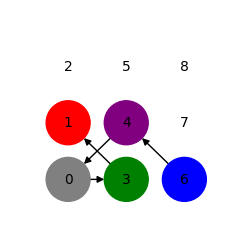

In [34]:
most_likely_trajectory = return_most_likely_trajectory(hmm_random,obs_trajectory_random)
print("most likely trajectory:", most_likely_trajectory)

draw_trajectory(Graph_random,most_likely_trajectory)